### Causal Machine Learning

#### 1. Feature Importance

In [1]:
import pandas as pd
import numpy as np

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

In [2]:
trnsX, cont = get_test_data(n_features = 20, n_informative = 5, n_redundant = 5, n_samples = 1000)

**1.1 $p-\mathrm{value}$**

In [3]:
import statsmodels.api as sm
ols = sm.Logit(cont['bin'], trnsX).fit()

         Current function value: 0.438438
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    bin   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      985
Method:                           MLE   Df Model:                           14
Date:                Mon, 01 Jan 2024   Pseudo R-squ.:                  0.3675
Time:                        18:30:00   Log-Likelihood:                -438.44
converged:                      False   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                9.339e-100
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I_0           -0.1891        nan        nan        nan         nan         nan
I_1           -0.2298   2.29e+06     -1e-07      1.000   -4.49e+0

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'p-values')

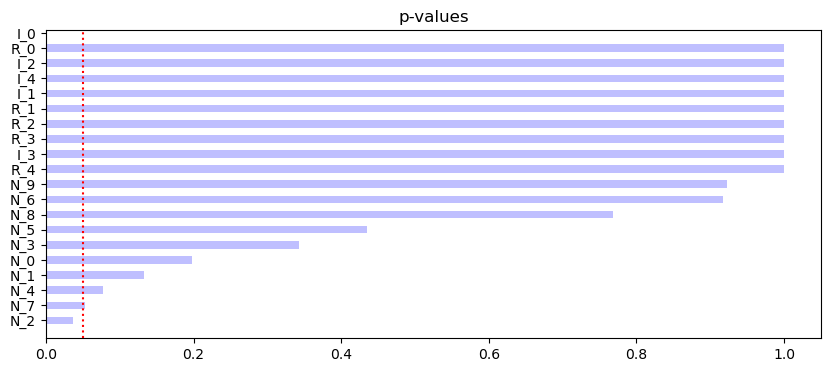

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)
plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')

**1.2 Mean Decrease Importance**

In [5]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from feature_importances import *

In [6]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

In [7]:
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont['t1'])

In [8]:
oos_score = ml_cross_val_score(forest, trnsX, cont['bin'], cv_gen = cv_gen, scoring = accuracy_score).mean()

In [9]:
mdi = mean_decrease_impurity(fit, trnsX.columns)

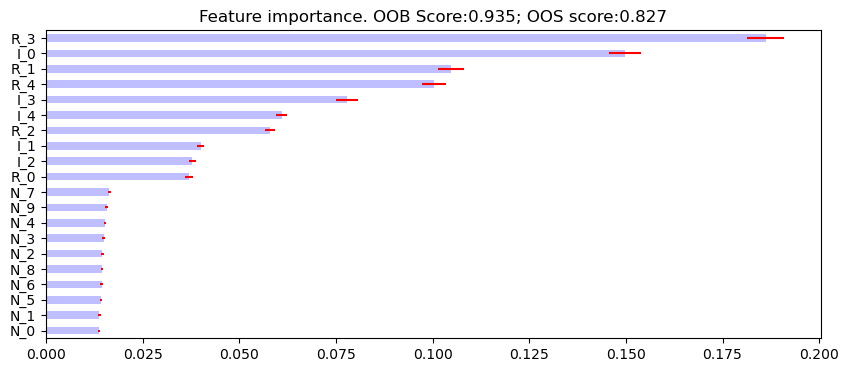

In [10]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

**1.3 Mean Decrease Accuracy**

In [11]:
mda = mean_decrease_accuracy(fit, trnsX, cont['bin'], cv_gen, scoring = accuracy_score)

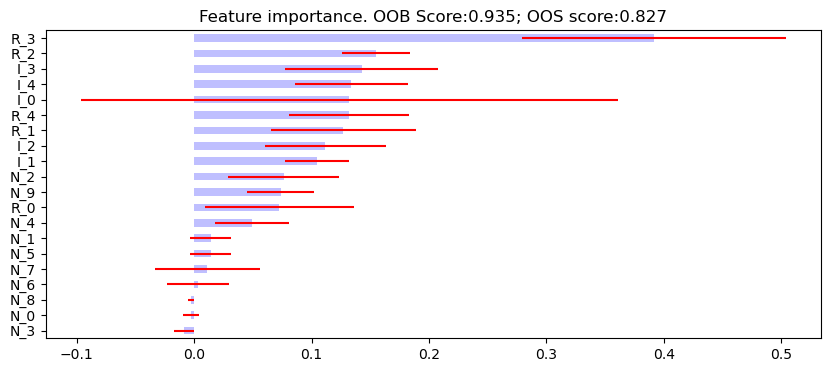

In [12]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

**1.4 Probability Weighted Accuracy**

In [13]:
y_pred = fit.predict(trnsX)
y_prob = fit.predict_proba(trnsX)

In [14]:
probability_weighted_accuracy(y_true = cont['bin'], y_pred = y_pred, probabilities = y_prob[:,1])

0.9405351053812927

#### 2. SHAP Value

#### 3. Double Machine Learning